[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod4_2_histograms.ipynb)

# Histograms

Histograms are another very common and useful graph to create and can show important shifts in the distribution of data, such as nighttime light intensity.

In this exercise, we'll look at Berlin, Germany. And as in {doc}`mod4_1_time_series_charts`, we'll need to extract the data from the raster.

**Our tasks in this exercise:**
1. Extract data for Berlin from a 2019 VIIRS-DNB composite and convert it to a numpy array
2. Create a histogram of VIIRS data for Berlin in Dec 2019 and compare to Dec 2018
3. Create a histogram of DMSP-OLS data for Berlin in 1992 and 2013

## Extract data from a region around Atlanta

Let's define a region around the metro area of Atlanta, Georgia and we'll get a composite of VIIRS-DNB `avg_rad` representing the median radiance for 2019.

We'll visualize it quickly to get our bearings (clipping our VIIRS layer to our rectangle).

In [1]:
#!pip install geemap
# !pip install --upgrade seaborn

In [2]:
import geemap, ee
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# define region of Berline
berlin = ee.Feature(ee.FeatureCollection(
    "FAO/GAUL_SIMPLIFIED_500m/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Berlin')).first())

# viirs for December 2019
viirsDec2019 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-12-01','2019-12-31').select('avg_rad').first()

berlinMap = geemap.Map()
berlinMap.centerObject(berlin, zoom=10)
berlinMap.addLayer(viirsDec2019.clip(berlin), {'min':1,'max':20}, opacity=.6)
berlinMap

Map(center=[52.503080254438004, 13.39870699912187], controls=(WidgetControl(options=['position'], widget=HBox(…

### Extracting data to array
We'll use `geemap`'s `sampleRectangle()` method to extract an array of radiance values from pixels in our raster within our region and use this to create our numpy array from the `avg_rad` band we've already selected. 

In [3]:
dec19arr = np.array(viirsDec2019.sampleRectangle(region=berlin.geometry()).get('avg_rad').getInfo())

### Plot histogram

Once again, we use `seaborn` to plot a histogram with our array.

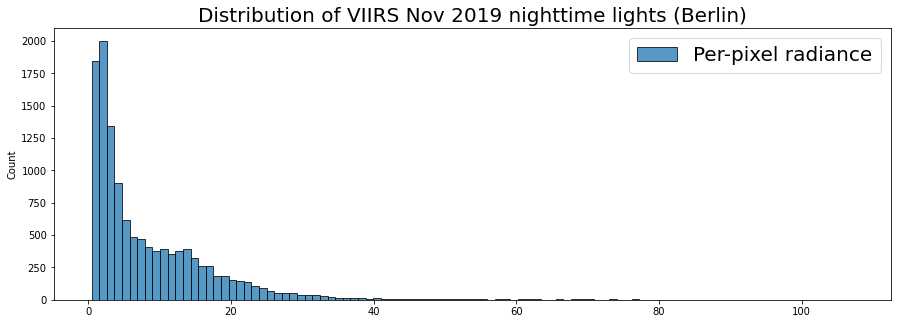

In [4]:
# first, we flatten our array to a 1-d array for the plot
data = dec19arr.flatten()

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data, bins=100, label='Per-pixel radiance',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Nov 2019 nighttime lights (Berlin)', fontsize=20);

Here we have a histogram of the region. We see that the vast majority of values are close to zero while there seems to be some extreme values past 100 (Watts/cm2/sr).

Often with such an extreme skew, it's helpful to visualize by applying a logscale, which we can do with `numpy`'s `.log()` function.

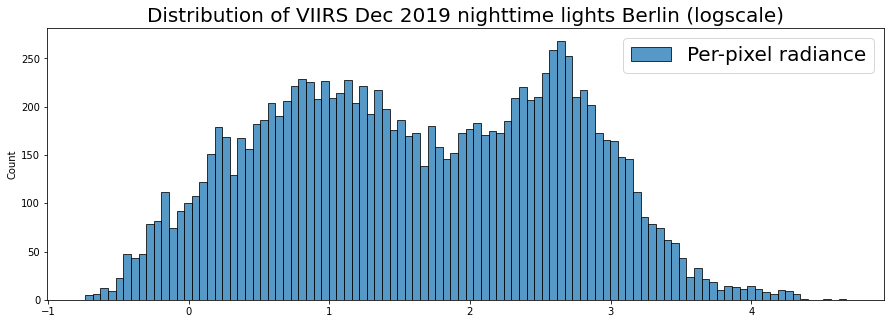

In [5]:
# logscale the data
data = np.log(dec19arr).flatten()

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data, bins=100, label='Per-pixel radiance',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Dec 2019 nighttime lights Berlin (logscale)', fontsize=20);

This let's us see the subtlety of the distribution a bit more. We can see somewhat of a bi-model distribution: the large tendency near zero, but another concentration higher up.

This may be useful in looking at trends, because we can see if the distribution changes. Let's compare this distribution from Dec 2019 to that of the previous year, Dec 2018.

We'll use `seaborn`'s `kdeplot()`, which plots the probability density smoothed with a Gaussian kernel...it makes it a bit easier to compare multiple distributions.

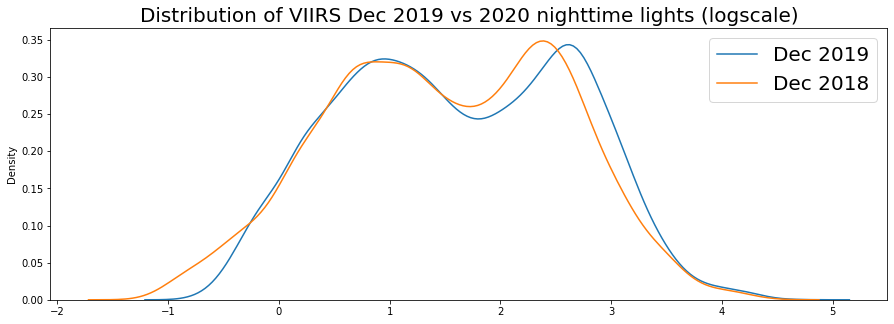

In [6]:
viirsDec18 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2018-12-01','2018-12-31').select('avg_rad').first()

dec18arr = np.array(viirsDec18.sampleRectangle(region=berlin.geometry()).get('avg_rad').getInfo())

fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(np.log(dec19arr).flatten(), label='Dec 2019',legend=True, ax=ax)
sns.kdeplot(np.log(dec18arr).flatten(), label='Dec 2018',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS Dec 2019 vs 2020 nighttime lights (logscale)', fontsize=20);

2019 seems to show a shift rightward for the right-most mode of our distribution. As we get data in for 2020, it would be interesting to compare this.

We're looking at an entire region, but you can also think about ways to compare urban vs suburban change by creating masks for urban core versus suburban areas. And with distributions, you can use statistical tests of variance to support analytical comparisons.

## Histogram of DMSP-OLS for Berlin in 2013

Because we'd need to calibrate for DMSP-OLS comparisons across satellites we won't compare years, but we can look at a histogram for 2013.

In [7]:
# get annual composites for 2013, stable lights
dmsp13 = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS").filterDate('2013-01-01','2013-12-31').select('stable_lights').first()

# extract data to array
arr13 = np.array(dmsp13.sampleRectangle(region=berlin.geometry()).get('stable_lights').getInfo())

In [8]:
berlinMap2 = geemap.Map()
berlinMap2.centerObject(berlin, zoom=10)
berlinMap2.addLayer(dmsp13.clip(berlin), {'min':0,'max':63}, opacity=.6)
berlinMap2

Map(center=[52.503080254438004, 13.39870699912187], controls=(WidgetControl(options=['position'], widget=HBox(…

You can see that the lower resolution and saturation issue with DMSP-OLS means this distribution likely wont be as dynamic.

In [9]:
print(f'VIIRS-DNB composite for Berlin has {dec19arr.size} datapoints')
print(f'DMSP-OLS composite for Berlin has {arr13.size} datapoints')

VIIRS-DNB composite for Berlin has 12400 datapoints
DMSP-OLS composite for Berlin has 3120 datapoints


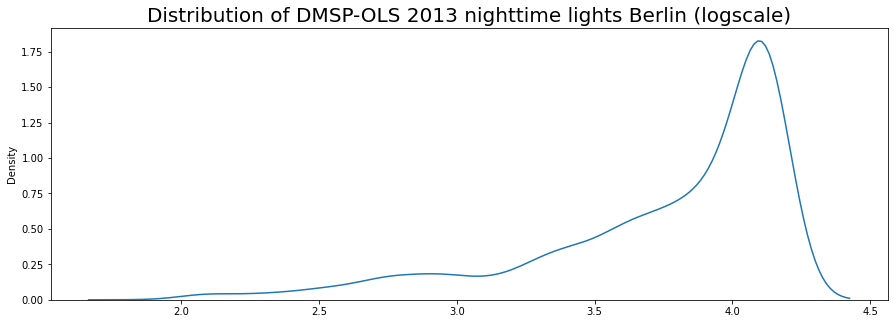

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(np.log(arr13).flatten(), legend=False, ax=ax)
plt.title('Distribution of DMSP-OLS 2013 nighttime lights Berlin (logscale)', fontsize=20);

We have a lot of saturated pixels, which would explain our high concentration at the high end of the range.

## References:
```{bibliography} ../references.bib
:filter: docname in docnames
```